# 2022 Comparative analysis benchmark

Logbook: https://docs.google.com/document/d/1NsqY_mA7U-jY2aLQlaQimiNLaRvYVx26cAia8HTdG_M/edit#


In [26]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display
import pandas as pd

import seaborn as sns

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy as sp
import os, re
import glob
from tqdm.auto import tqdm
import tempfile
from itertools import product


In [2]:
# MODIFICATIONS = [
#     'H3K4me2', 'H3K4me3', 'H3K9ac' 'H3K27ac', # narrow
#     'H3K4me1', 'H3K9me3', 'H3K27me3', 'H3K36me3', 'H3K79me2', # broad
#     'H3K4ac', 'H3K56ac', 'H3K79me1' # mixed
# ]

# Core histone marks
MODIFICATIONS = [
    'H3K4me3', 'H3K4me1', 'H3K27me3', 'H3K36me3'
]

PATH = os.path.expanduser('~/data/2022_comparative_analysis')
FIGURES_DIR = os.path.join(PATH, 'pics')
EXT = 'pdf'
! mkdir -p {FIGURES_DIR}

In [3]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0


def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

## MACS2

In [4]:
MACS2_FOLDER = f'{PATH}/macs2'
MACS2_LEVELS = ['q0.05', 'broad0.1']

dfm = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(MACS2_FOLDER + '/*.*Peak')):
    if 'gapped' in file:
        continue
    level = next((l for l in MACS2_LEVELS if f'_{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfm.loc[len(dfm)] = (modification, replicate, f'macs2 {level}', file, peaks)

  0%|          | 0/111 [00:00<?, ?it/s]

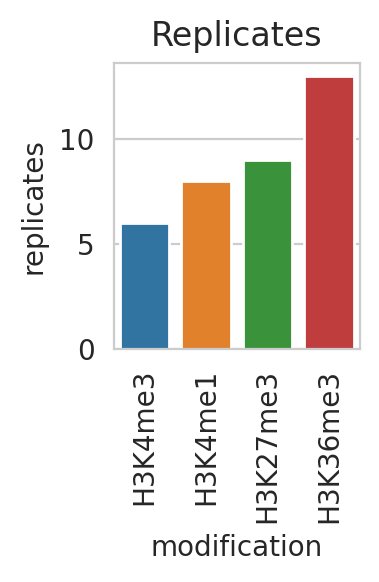

In [5]:
t = (dfm.groupby(['modification'])['file'].count() / len(MACS2_LEVELS)).astype(int)
plt.figure(figsize=(2, 3))
sns.barplot(data=pd.DataFrame(dict(modification=t.index, replicates=t)), x='modification', y='replicates',
            order=MODIFICATIONS)
plt.xticks(rotation=90)
plt.title('Replicates')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'replicates_macs2.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [6]:
macs2levels2process = {'macs2 q0.05', 'macs2 broad0.1'}

## SICER

In [7]:
SICER_FOLDER = f'{PATH}/sicer'
SICER_LEVELS = ['FDR0.01']

dfsc = pd.DataFrame(columns=['modification', 'replicate', 'level', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SICER_FOLDER + '/*islands-summary*')):
    level = next((l for l in SICER_LEVELS if f'-{l}' in file), None)
    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    if level and modification:
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfsc.loc[len(dfsc)] = (modification, replicate, f'sicer {level}', file, peaks)

  0%|          | 0/37 [00:00<?, ?it/s]

In [8]:
sicerlevels2process = {'sicer FDR0.01'}

## SPAN

In [9]:
SPAN_FOLDER = f'{PATH}/span'
FDRS = ['0.05']

dfs = pd.DataFrame(columns=['modification', 'replicate', 'level', 'fdr', 'file', 'peaks'], dtype=object)
for file in tqdm(glob.glob(SPAN_FOLDER + '/*.peak')):
    if 'Input' in file:
        continue

    modification = next((m for m in MODIFICATIONS if f'_{m}' in file), None)
    fdr = next((f for f in FDRS if f'_{f}' in file), None)
    if modification and fdr is not None:
        level = f'span 100_{fdr}'
        replicate = os.path.basename(file).replace(f'H1_{modification}_', '')[:3]
        peaks = lines(file)
        dfs.loc[len(dfs)] = (modification, replicate, level, fdr, file, peaks)

  0%|          | 0/37 [00:00<?, ?it/s]

In [10]:
spanlevels2process = {'span 100_0.05'}

## Summary

In [11]:
dfa = pd.concat([
    dfm.loc[[l in macs2levels2process for l in dfm['level']]],
    dfs.loc[[l in spanlevels2process for l in dfs['level']]],
    dfsc.loc[[l in sicerlevels2process for l in dfsc['level']]],
    dfs.loc[[l in spanlevels2process for l in dfs['level']]]
]).reset_index(drop=True)
display(dfa['level'].unique())

dfa['name'] = ''
dfa.loc[dfa['level'] == 'macs2 q0.05', 'name'] = 'MACS2'
dfa.loc[dfa['level'] == 'macs2 broad0.1', 'name'] = 'MACS2 broad'
dfa.loc[dfa['level'] == 'sicer FDR0.01', 'name'] = 'SICER'
dfa.loc[dfa['level'] == 'span 100_0.05', 'name'] = 'SPAN'
dfa.sample(5)

array(['macs2 q0.05', 'macs2 broad0.1', 'span 100_0.05', 'sicer FDR0.01'],
      dtype=object)

,modification,replicate,level,file,peaks,fdr,name
172,H3K27me3,5_2,span 100_0.05,/home/jetbrains/data/2022_comparative_analysis...,10768,0.05,SPAN
65,H3K36me3,2_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,14428,NaN,MACS2
64,H3K36me3,4_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,33530,NaN,MACS2 broad
92,H3K27me3,4_1,span 100_0.05,/home/jetbrains/data/2022_comparative_analysis...,13291,0.05,SPAN
59,H3K36me3,6_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,15549,NaN,MACS2


# Group analysis

In [12]:
def plot_data_cells(
        df, cid, value, description, bar=True, swarm=True, order=None, lower=None, upper=None, figx=None, figy=None
):
    cids = list(set(df[cid]))
    axs = {}
    total = len(cids) * len(MODIFICATIONS)
    plt.figure(figsize=(figx or int(total / 3), figy or 4))
    offset = 0
    for m in MODIFICATIONS:
        data = df.loc[df['modification'] == m].sort_values(by=[cid])
        w = len(cids)
        ax = plt.subplot2grid((1, total), (0, offset), colspan=w)

        if bar:
            sns.barplot(data=data,
                        x=cid, y=value,
                        capsize=.2, errwidth=2,
                        ax=ax,
                        order=order)
        else:
            sns.boxplot(data=data, x=cid, y=value, showfliers=False, ax=ax,
                        order=order)
        if swarm:
            sns.swarmplot(data=data,
                          x=cid, y=value,
                          size=4,
                          color="black",
                          alpha=0.8,
                          ax=ax,
                          order=order)

            # ax.legend().remove()
        axs[ax] = plt.ylim()
        if offset > 0:
            ax.get_yaxis().set_ticklabels([])
            ax.set_ylabel('')
        else:
            ax.set_ylabel(description)

        offset += w
        ax.set_xlabel('')
        ax.set_title(m)
        ax.xaxis.set_tick_params(rotation=90)

    ymin = np.min([v[0] for v in axs.values()])
    if lower is not None:
        ymin = max(ymin, lower)
    ymax = np.max([v[1] for v in axs.values()])
    if upper is not None:
        ymax = min(ymax, upper)

    for ax in axs.keys():
        ax.set_ylim(bottom=ymin, top=ymax)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{value}.{EXT}'), bbox_inches='tight', dpi=300)
    plt.show()


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 22.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWar

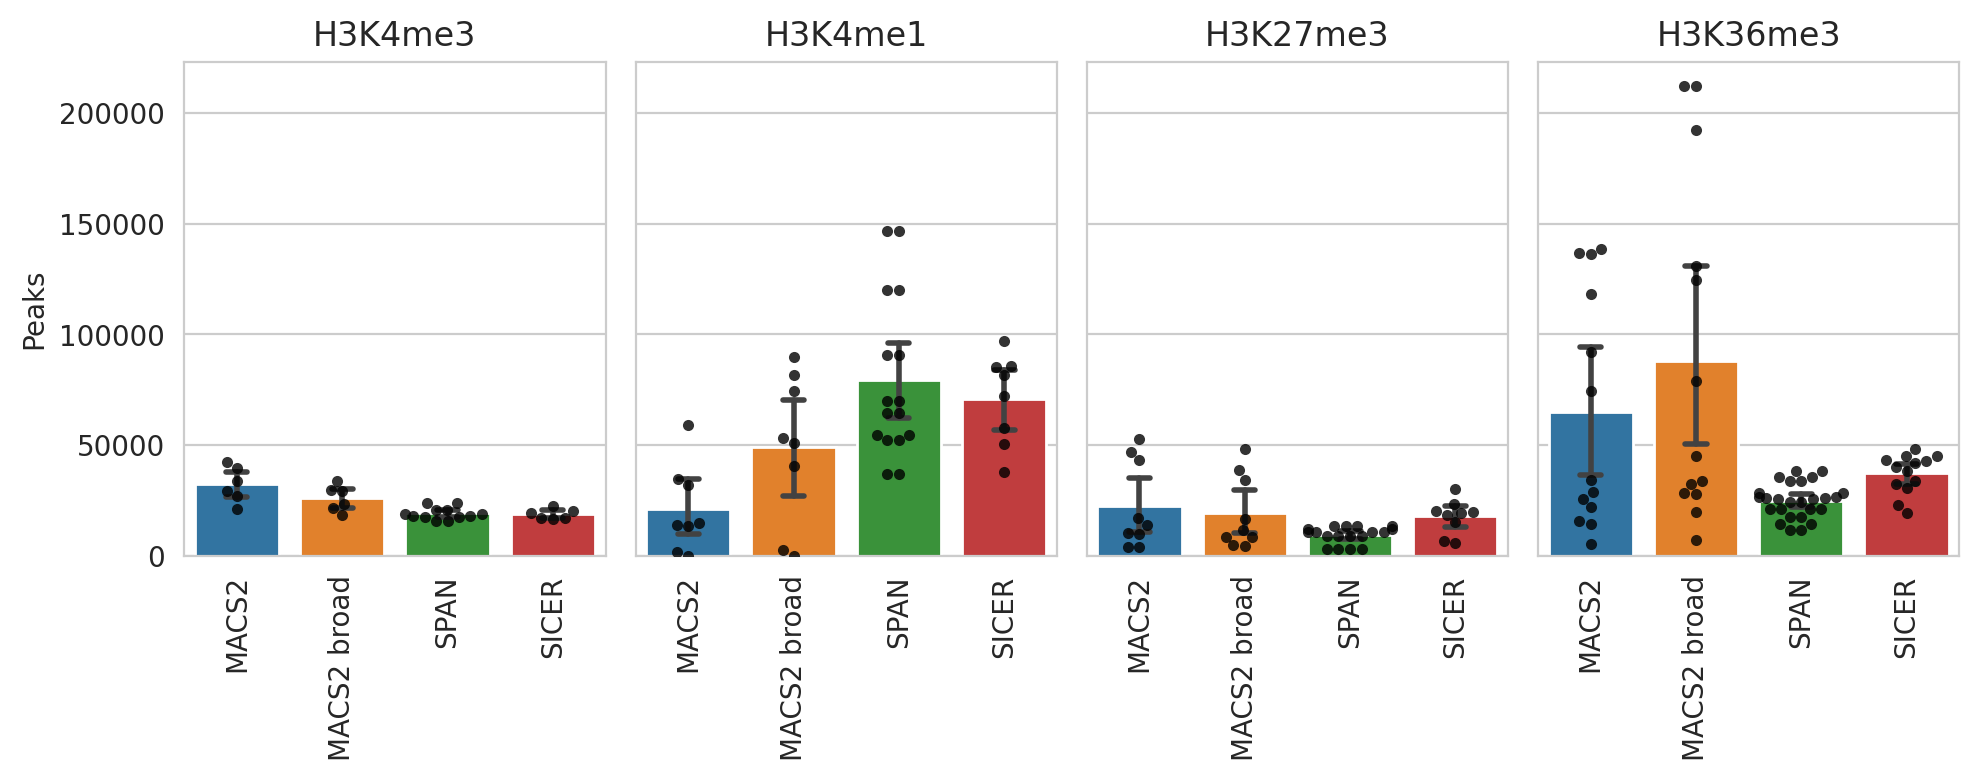

In [13]:
plot_data_cells(dfa, 'name', 'peaks', 'Peaks', figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

In [14]:
dfa[(dfa['modification'] == 'H3K4me1') & (dfa['peaks'] < 10000)]

# Filter out bad quality and super high quality data
dfa = dfa[~((dfa['modification'] == 'H3K4me1') & ((dfa['replicate'] == '1_1') |
                                                  (dfa['replicate'] == '1_2')))]
dfa = dfa[~((dfa['modification'] == 'H3K27me3') & (dfa['replicate'] == '1_1'))]
dfa = dfa[~((dfa['modification'] == 'H3K36me3') & ((dfa['replicate'] == '1_1') |
                                                   (dfa['replicate'] == '2_1')))]

dfa

,modification,replicate,level,file,peaks,fdr,name
0,H3K36me3,4_2,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,28534,NaN,MACS2
1,H3K27me3,4_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,11423,NaN,MACS2 broad
2,H3K4me1,5_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,2378,NaN,MACS2 broad
3,H3K4me1,3_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,89903,NaN,MACS2 broad
4,H3K4me1,4_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,13398,NaN,MACS2
...,...,...,...,...,...,...,...
175,H3K36me3,5_4,span 100_0.05,/home/jetbrains/data/2022_comparative_analysis...,25935,0.05,SPAN
176,H3K4me1,5_1,span 100_0.05,/home/jetbrains/data/2022_comparative_analysis...,146788,0.05,SPAN
177,H3K36me3,4_1,span 100_0.05,/home/jetbrains/data/2022_comparative_analysis...,24272,0.05,SPAN
178,H3K36me3,5_2,span 100_0.05,/home/jetbrains/data/2022_comparative_analysis...,35642,0.05,SPAN


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWar

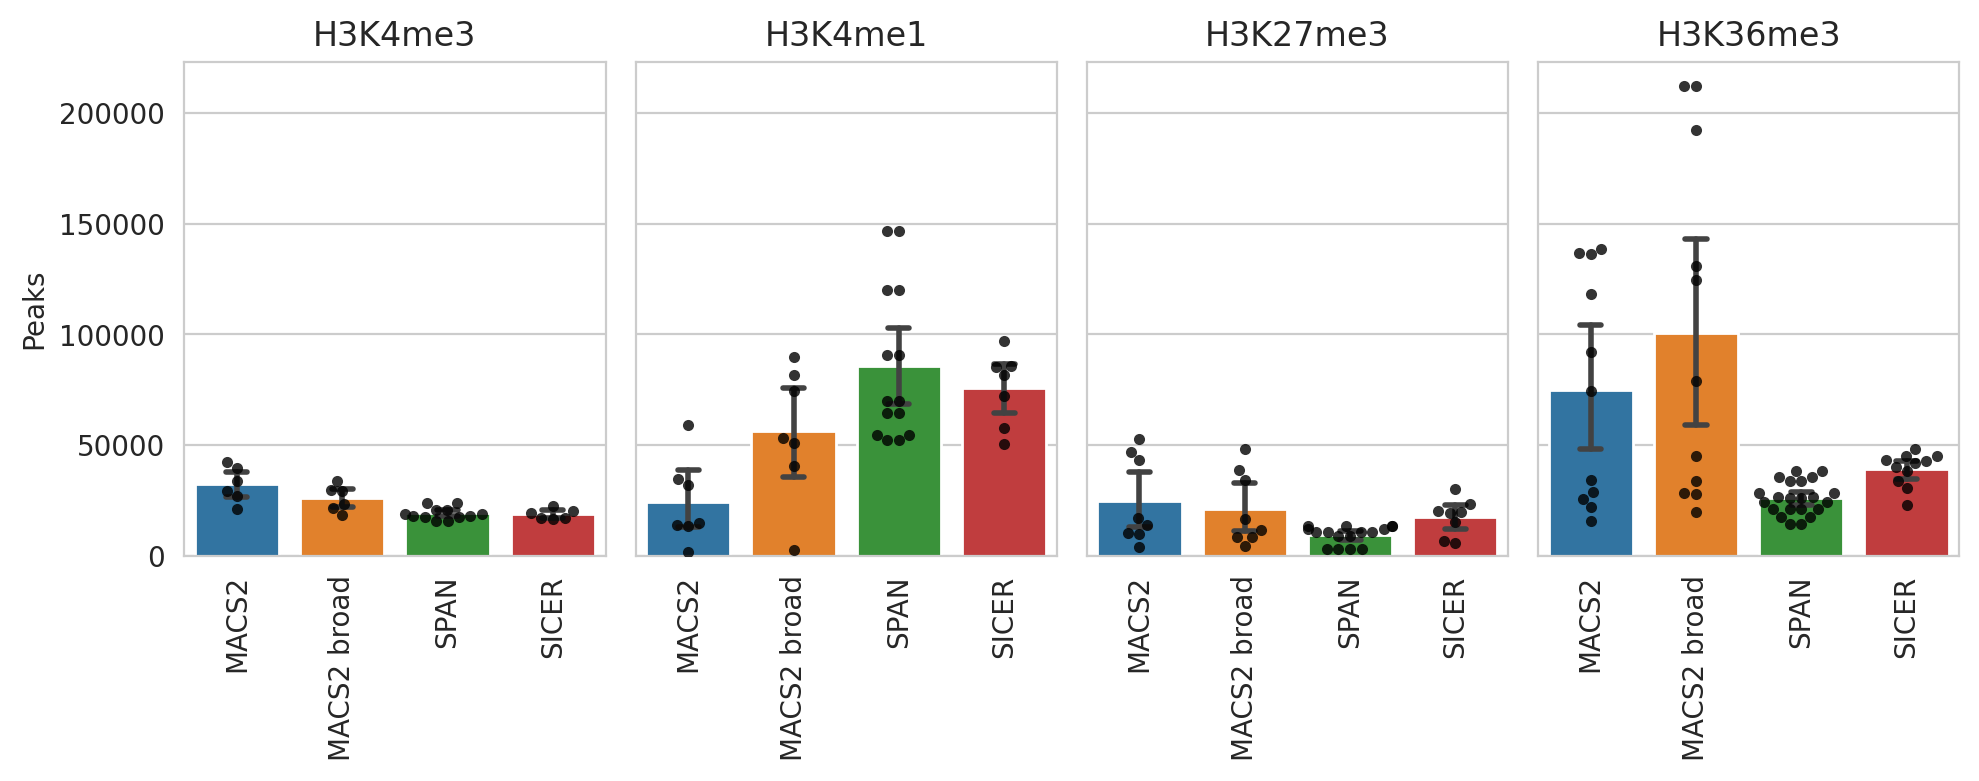

In [15]:
plot_data_cells(dfa, 'name', 'peaks', 'Peaks', figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

In [16]:
ts = []
for modification, name, file in tqdm(zip(dfa['modification'], dfa['name'], dfa['file'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t['modification'] = modification
    t['name'] = name
    ts.append(t.sample(min(len(t), 20_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

0it [00:00, ?it/s]

,length,modification,name
1348911,5360,H3K4me1,SPAN
2295464,2550,H3K36me3,SPAN
1061760,657,H3K4me3,MACS2
2509885,1560,H3K4me3,SPAN
1472277,1100,H3K27me3,SPAN
317983,2229,H3K27me3,MACS2 broad
744485,617,H3K27me3,MACS2
288914,226,H3K27me3,MACS2
1287947,2460,H3K36me3,SPAN
1439655,1240,H3K4me3,SPAN


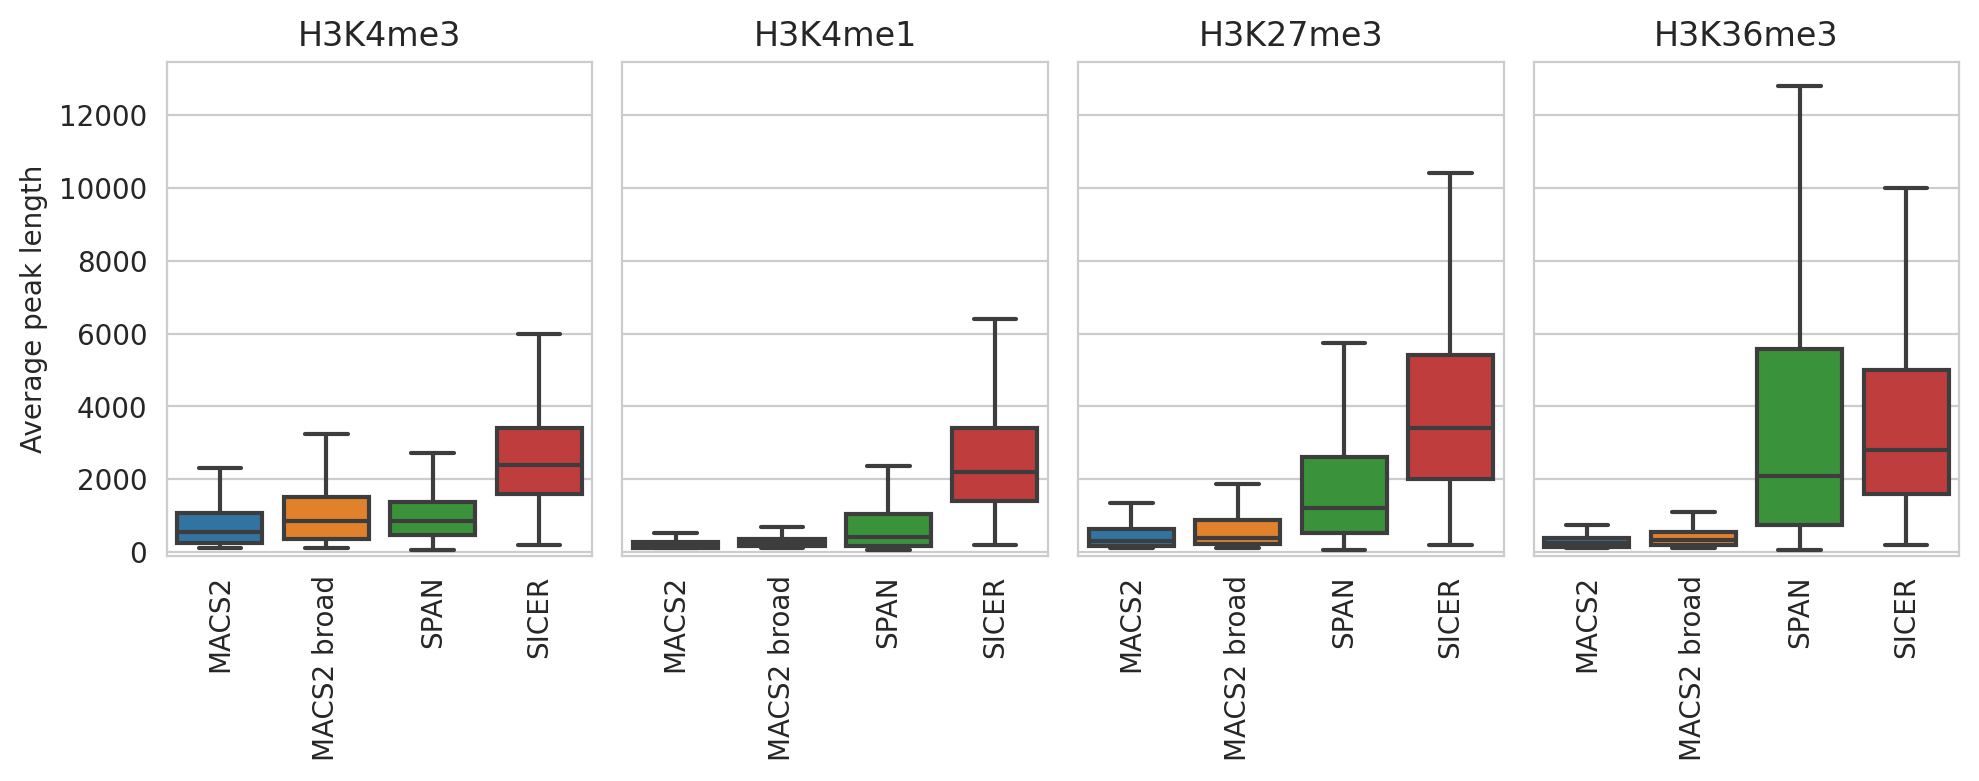

In [17]:
plot_data_cells(t, 'name', 'length', 'Average peak length', bar=False, swarm=False,
                lower=-100, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])

# Difference between tools

In [18]:
diff_df = pd.DataFrame(
    columns=['modification', 'replicate', 'name', 'peaks'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

tools = list(sorted(set(dfa['name'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(len(tools)):
                if i == j:
                    continue
                tool1, tool2 = tools[i], tools[j]
                if tool1 != 'SPAN' and tool2 != 'SPAN':
                    continue
                t1 = tm.loc[(tm['name'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['name'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                name = f'{tool1} - {tool2}'
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -v > {tf}
                peaks = lines(tf)
                diff_df.loc[len(diff_df)] = \
                    (m, rep, name, peaks)
diff_df.sample(5)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


,modification,replicate,name,peaks
184,H3K36me3,6_1,SPAN - MACS2 broad,14035
151,H3K36me3,5_1,MACS2 broad - SPAN,53854
108,H3K27me3,5_3,MACS2 - SPAN,18995
43,H3K4me1,3_1,MACS2 broad - SPAN,5603
63,H3K4me1,4_3,SPAN - MACS2,43085


In [19]:
diff_dfa = pd.concat([diff_df, dfa[['modification', 'replicate', 'name', 'peaks']]]).reset_index(drop=True)
diff_dfa.sample(5)

,modification,replicate,name,peaks
219,H3K27me3,5_3,MACS2 broad,38605
290,H3K4me3,7_1,SICER,20345
196,H3K4me1,4_1,MACS2,13398
301,H3K36me3,7_1,SICER,48029
238,H3K4me1,4_2,MACS2 broad,53051


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWar

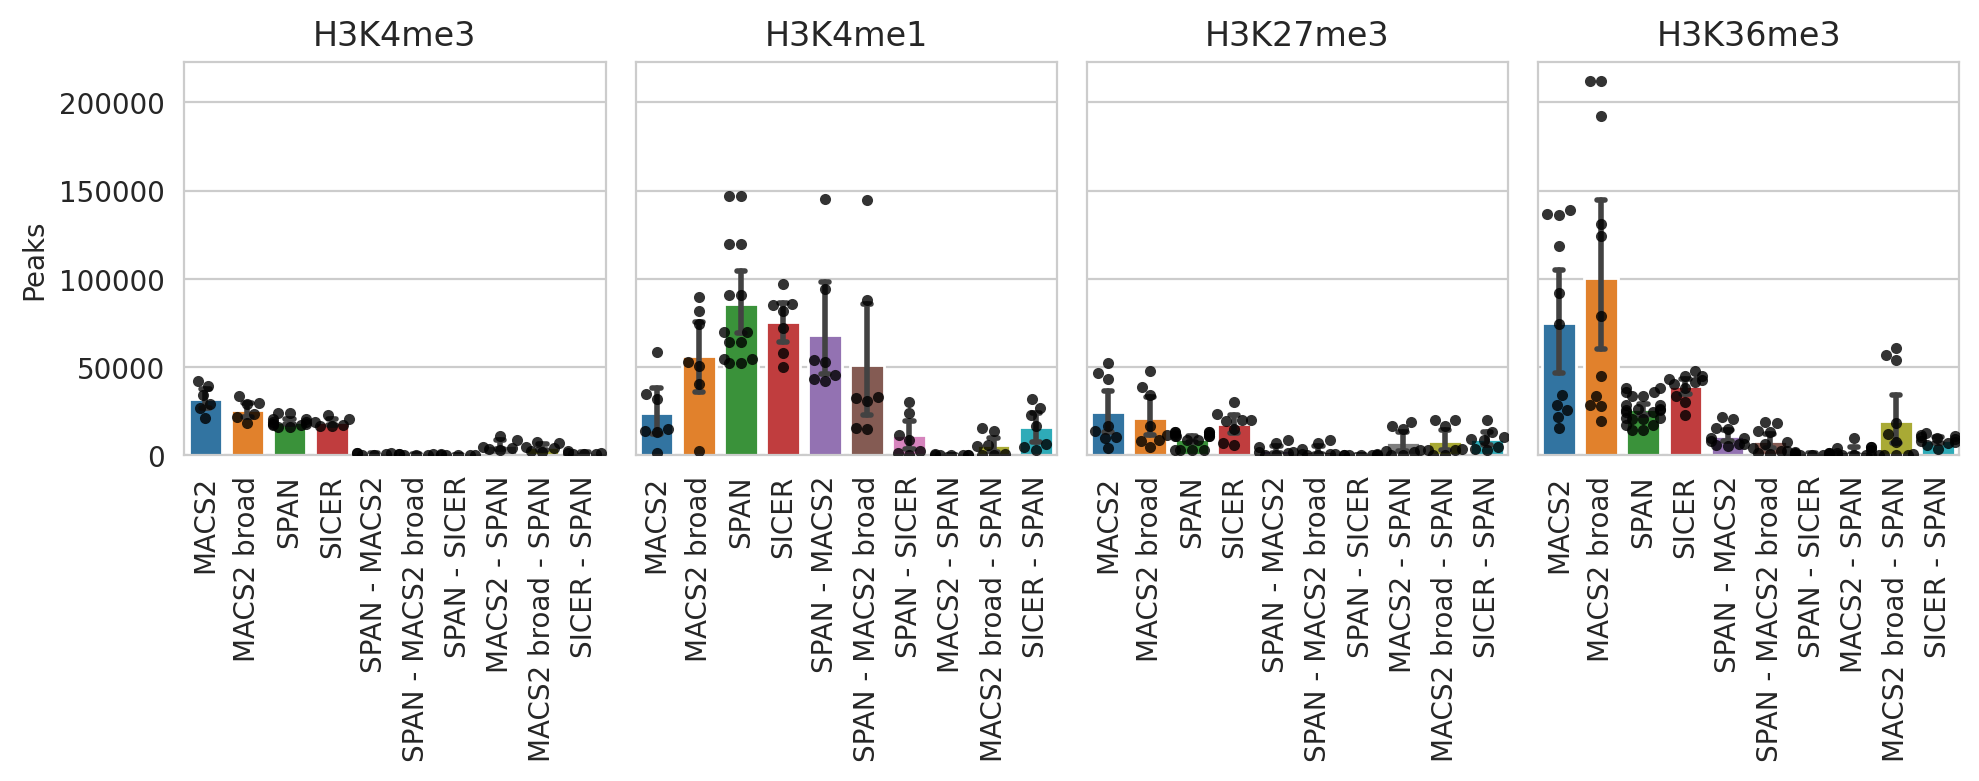

In [20]:
plot_data_cells(diff_dfa, 'name', 'peaks', 'Peaks', swarm=True, figx=10, figy=4,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])

# Jaccard between replicates

In [27]:
dfa[dfa['modification'] == m]

,modification,replicate,level,file,peaks,fdr,name
0,H3K36me3,4_2,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,28534,NaN,MACS2
5,H3K36me3,5_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,192276,NaN,MACS2 broad
7,H3K36me3,5_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,92235,NaN,MACS2
8,H3K36me3,5_2,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,130818,NaN,MACS2 broad
12,H3K36me3,4_2,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,27960,NaN,MACS2 broad
15,H3K36me3,7_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,124457,NaN,MACS2 broad
16,H3K36me3,5_3,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,74612,NaN,MACS2
21,H3K36me3,7_1,macs2 q0.05,/home/jetbrains/data/2022_comparative_analysis...,118448,NaN,MACS2
25,H3K36me3,5_5,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,212330,NaN,MACS2 broad
28,H3K36me3,3_1,macs2 broad0.1,/home/jetbrains/data/2022_comparative_analysis...,28264,NaN,MACS2 broad


In [28]:
import tempfile
import pyranges as pr

def compute_reps_overlap(df_peaks, modifications):
    reps_overlap = pd.DataFrame(columns=['modification', 'tool', 'rep1', 'rep2',
                                         'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                         'peaks1_overlap', 'peaks2_overlap', 'peaks_overlap_len'], dtype=object)

    tools = df_peaks['level'].unique()
    for m in tqdm(modifications):
        print(m)
        tm = df_peaks[df_peaks['modification'] == m]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            files = [None] * len(reps)
            peaks = [-1] * len(reps)
            peaks_lens = [-1] * len(reps)
            # print('Load')
            for i in range(len(reps)):
                t1 = tm[(tm['level'] == tool) & (tm['replicate'] == reps[i])]
                if len(t1) == 0:
                    continue
                file = t1['file'].values[0]
                peaks[i] = lines(file)
                if peaks[i] == 0:
                    peaks_lens[i] = 0
                    continue
                files[i] = pr.read_bed(sorted_file(file))
                peaks_lens[i] = files[i].lengths().sum()
            # print('Intersect')
            for i, j in product(range(len(reps)), range(len(reps))):
                if i >= j:
                    continue
                rep1, rep2 = reps[i], reps[j]
                file1, file2 = files[i], files[j]
                peaks1, peaks2 = peaks[i], peaks[j]
                peaks1_len, peaks2_len = peaks_lens[i], peaks_lens[j]
                if peaks1 <= 0 or peaks2 <= 0:
                    reps_overlap.loc[len(reps_overlap)] = \
                        (m, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                         0, 0, 0)
                    continue
                overlap1 = len(file1.overlap(file2))
                overlap2 = len(file2.overlap(file1))
                overlap_len = file1.intersect(file2).lengths().sum()
                # assert file2.intersect(file1).lengths().sum() == overlap_len
                reps_overlap.loc[len(reps_overlap)] = \
                    (m, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap2, overlap_len)

    reps_overlap['jaccard'] = [
        d(lo, l1 + l2 - lo)
        for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks_overlap_len'])
    ]
    return reps_overlap

In [29]:
reps_overlap = compute_reps_overlap(dfa, MODIFICATIONS)
reps_overlap.sample(5)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


,modification,tool,rep1,rep2,peaks1,peaks1_len,peaks2,peaks2_len,peaks1_overlap,peaks2_overlap,peaks_overlap_len,jaccard
382,H3K36me3,span 100_0.05,3_1,5_5,17303,91423110,26321,142304930,15214,12631,81398710,0.534360
331,H3K36me3,macs2 broad0.1,4_1,5_1,33530,27696352,192276,53754853,26162,40178,13331936,0.195715
104,H3K4me1,span 100_0.05,2_1,4_2,69809,56562640,64449,66973060,37326,30282,26854460,0.277763
414,H3K36me3,span 100_0.05,5_3,7_1,38114,132392030,33680,108476989,21857,21351,79831740,0.495735
161,H3K27me3,macs2 q0.05,2_2,7_1,10360,10812677,52579,20310660,9557,13236,8952878,0.403820


In [30]:
# TODO use melt() here!
ro = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Overlap'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['peaks1_overlap']
    overlap2 = row['peaks1_overlap']
    ro.loc[len(ro)] = (m, f'{rep1} vs {rep2}', tool, d(overlap1, peaks1))
    ro.loc[len(ro)] = (m, f'{rep2} vs {rep1}', tool, d(overlap2, peaks2))
ro.sample(5)

,Modification,Replicate,Tool,Overlap
799,H3K36me3,7_1 vs 4_2,span 100_0.05,0.499020
622,H3K36me3,2_2 vs 3_1,macs2 broad0.1,0.234895
220,H3K4me1,3_1 vs 4_3,span 100_0.05,0.368910
687,H3K36me3,6_1 vs 4_2,macs2 broad0.1,0.471943
535,H3K36me3,4_2 vs 3_1,macs2 q0.05,0.206771


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


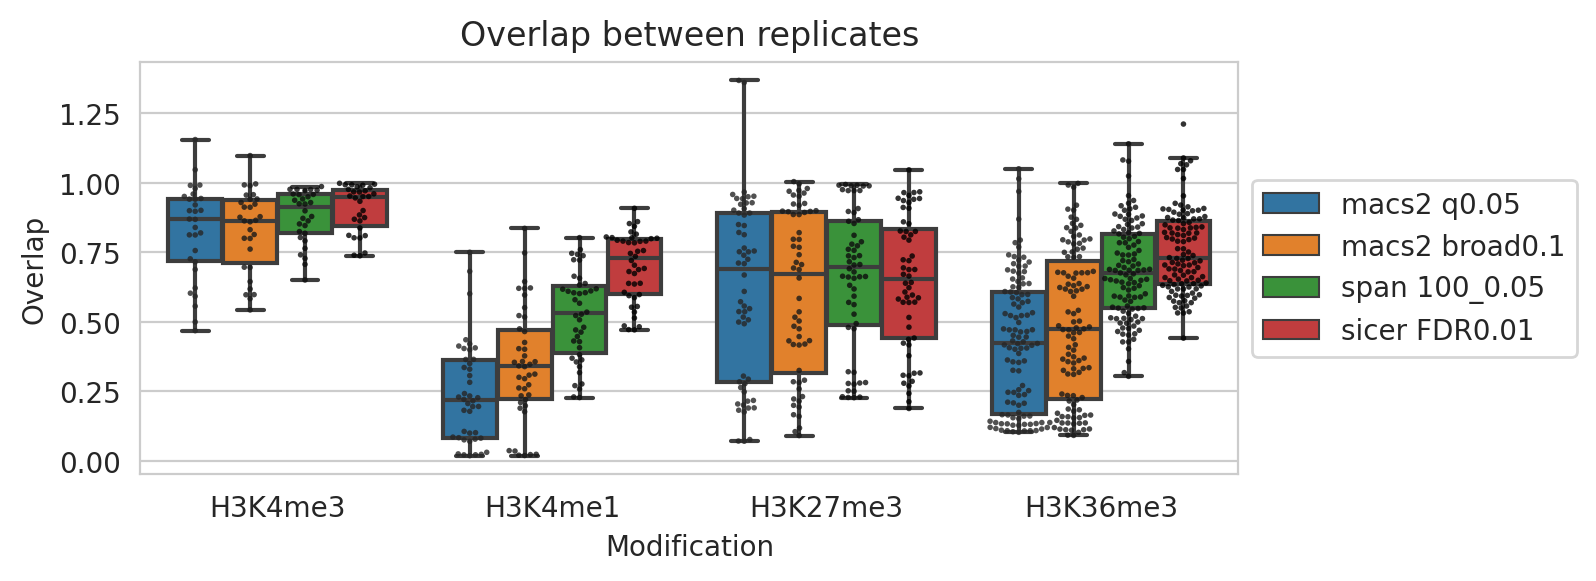

In [33]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
plt.title(f'Overlap between replicates')
sns.boxplot(data=ro, x='Modification', y='Overlap', hue='Tool',
            order=MODIFICATIONS,
            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            showfliers=False,
            ax=ax)
sns.swarmplot(data=ro, x='Modification', y='Overlap', hue='Tool',
              dodge=True, size=2, color="black", alpha=0.8,
              order=MODIFICATIONS,
              # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

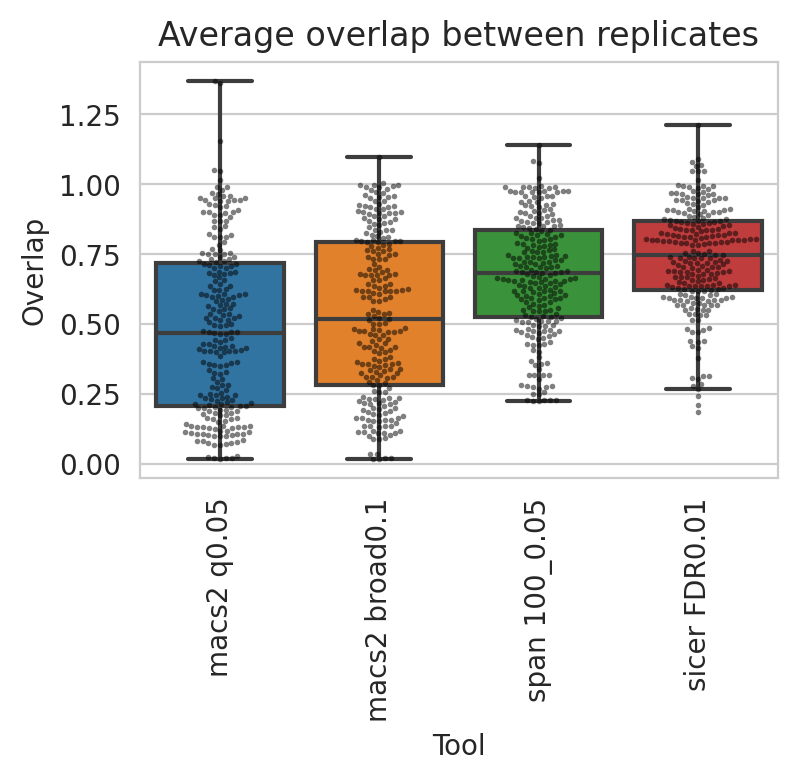

In [34]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
plt.title(f'Average overlap between replicates')
sns.boxplot(data=ro, x='Tool', y='Overlap', showfliers=False,
            # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=ro, x='Tool', y='Overlap',
              dodge=True, size=2, color="black", alpha=0.5,
              # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [35]:
rj = pd.DataFrame(columns=['Modification', 'Replicate', 'Tool', 'Jaccard'], dtype=object)
for _, row in reps_overlap.iterrows():
    m = row['modification']
    tool = row['tool']
    rep1 = row['rep1']
    rep2 = row['rep2']
    length1 = row['peaks1_len']
    length2 = row['peaks2_len']
    intersection = row['peaks_overlap_len']
    jaccard = d(intersection, length1 + length2 - intersection)
    rj.loc[len(rj)] = (m, f'{rep1} vs {rep2}', tool, jaccard)
rj.sample(5)

,Modification,Replicate,Tool,Jaccard
18,H3K4me3,1_1 vs 7_1,macs2 broad0.1,0.690182
31,H3K4me3,1_1 vs 3_1,span 100_0.05,0.680157
188,H3K27me3,2_2 vs 6_1,macs2 broad0.1,0.503289
28,H3K4me3,5_2 vs 8_1,macs2 broad0.1,0.407132
304,H3K36me3,5_3 vs 7_1,macs2 q0.05,0.098346


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


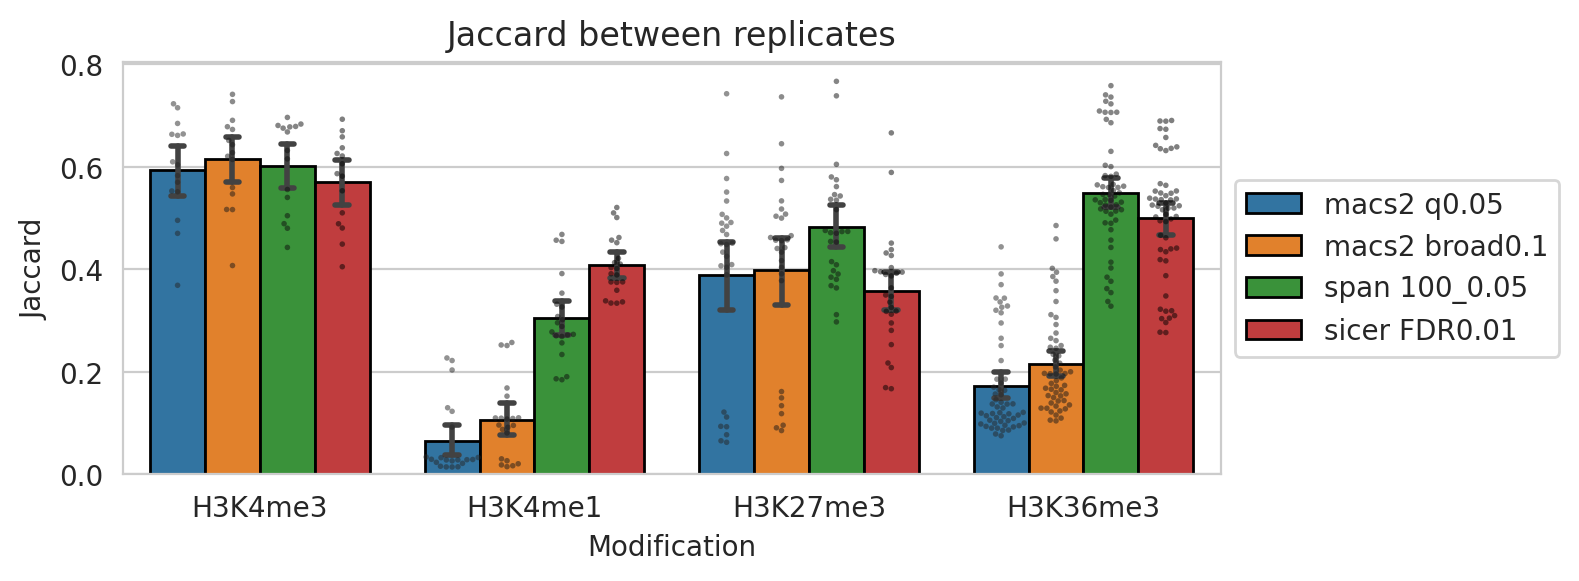

In [37]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
# plt.figure(figsize=(6, 4))
plt.title('Jaccard between replicates')
sns.barplot(data=rj, x='Modification', y='Jaccard', hue='Tool',
            order=MODIFICATIONS,
            # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            # showfliers=False,
            capsize=.05, errwidth=2, edgecolor="black",
            ax=ax)
sns.swarmplot(data=rj, x='Modification', y='Jaccard', hue='Tool',
              dodge=True, size=2, color="black", alpha=0.5,
              order=MODIFICATIONS,
              # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
# sns.boxplot(data=rj, x='Modification', y='Jaccard', hue='Tool')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.xaxis.set_tick_params(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [38]:
rows = []
for _, (modification, tool, p1, p2, l1, l2, ol) in reps_overlap[
    ['modification', 'tool', 'peaks1', 'peaks2', 'peaks1_len', 'peaks2_len', 'peaks_overlap_len']].iterrows():
    jaccard = d(ol, l1 + l2 - ol)
    rows.append((modification, tool, jaccard, d(l1, p1)))
    rows.append((modification, tool, jaccard, d(l2, p2)))
df_jaccard_avg_len = pd.DataFrame(rows, columns=['modification', 'tool', 'jaccard', 'average_len'])
del rows

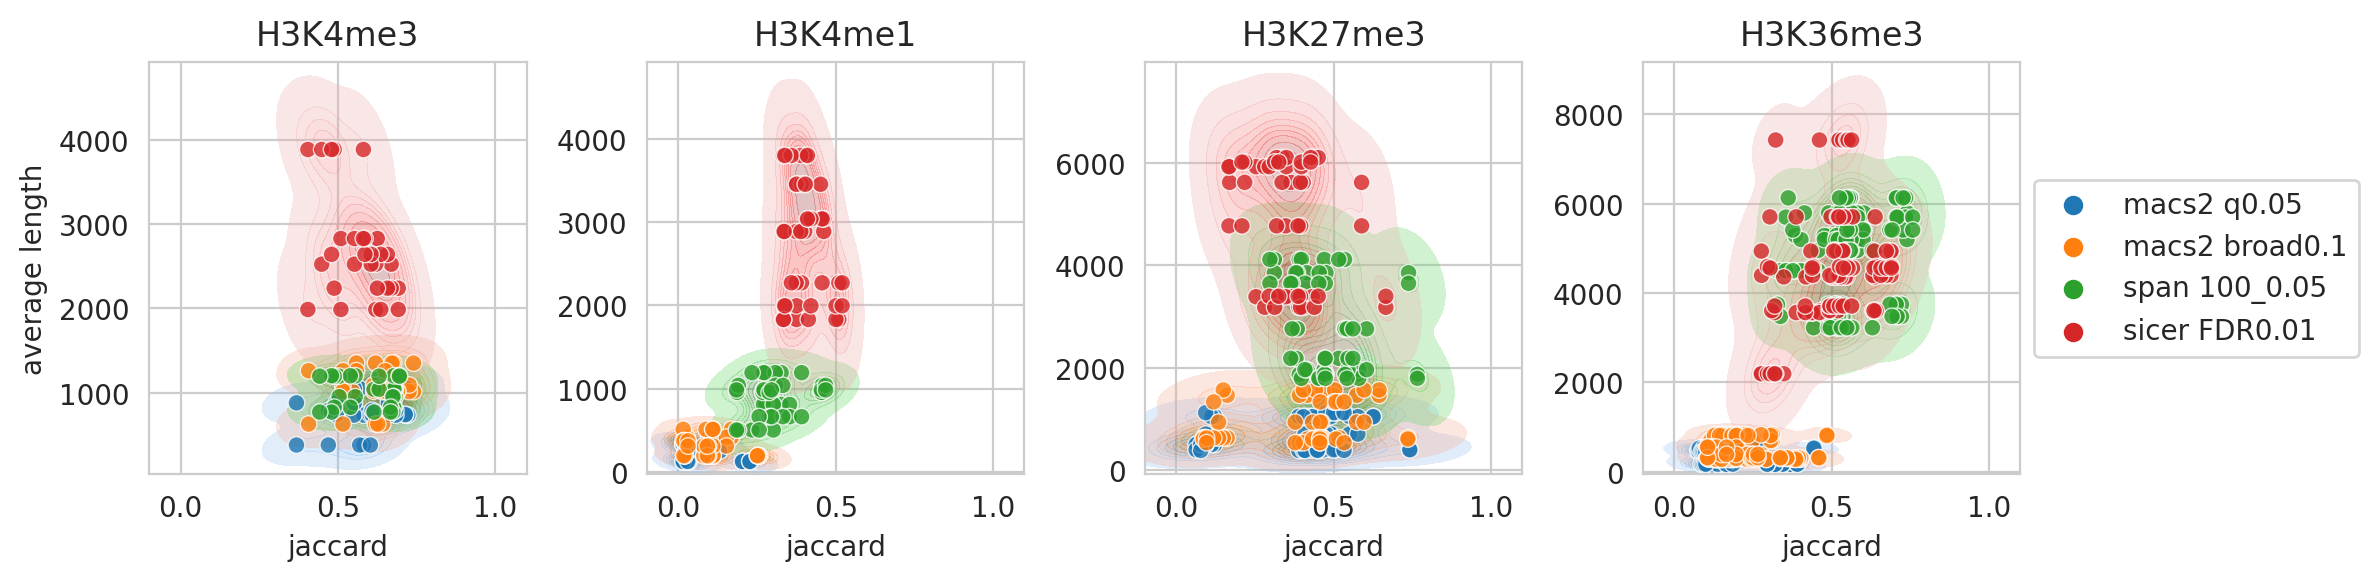

In [40]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    sns.kdeplot(
        df_jaccard_avg_len[df_jaccard_avg_len['modification'] == m],
        # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
        x='jaccard', y='average_len', hue='tool', alpha=0.3,
        common_norm=False, common_grid=False,
        thresh=.01,
        fill=True,
        ax = ax,
    )
    sns.scatterplot(
        df_jaccard_avg_len[df_jaccard_avg_len['modification'] == m],
        # palette=TOOLS_PALETTE,
        # hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
        x='jaccard', y='average_len', hue='tool', alpha=0.8,
        ax=ax,
    )
    ax.set_title(m)
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(m)
    if i > 0:
        ax.set_ylabel(None)
    else:
        ax.set_ylabel('average length')
    if i < len(axs) - 1:
        ax.legend().set_visible(False)
    else:
        #     Put a legend to the right of the current axis
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

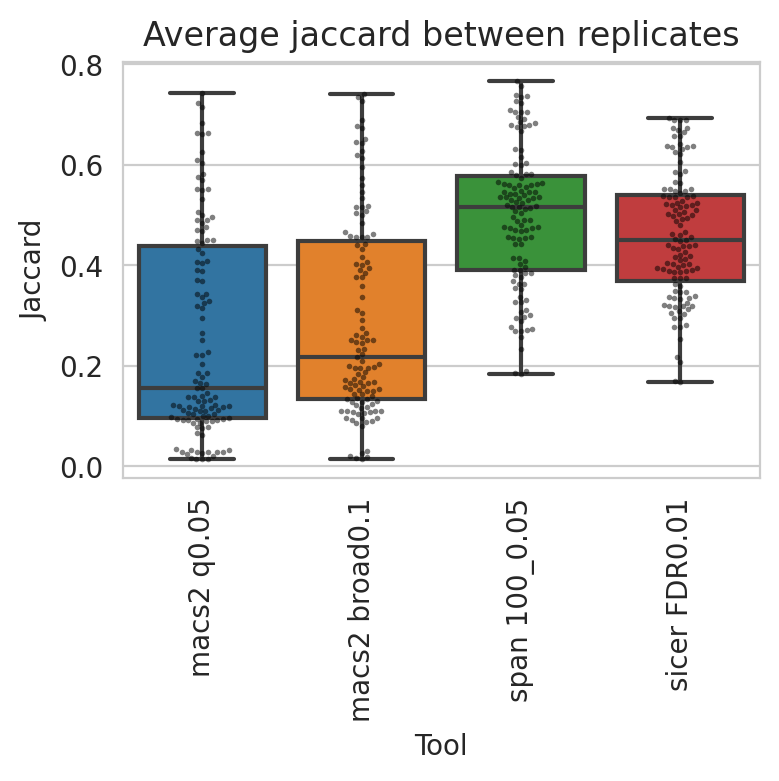

In [41]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
plt.title(f'Average jaccard between replicates')
sns.boxplot(data=rj, x='Tool', y='Jaccard', showfliers=False,
            # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=rj, x='Tool', y='Jaccard',
              dodge=True, size=2, color="black", alpha=0.5,
              # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

In [31]:
STOP

NameError: name 'STOP' is not defined

# IDR between replicates

In [ ]:
def compute_reps_idr(df_peaks, modifications, rank):
    reps_idr = pd.DataFrame(columns=['modification', 'tool', 'rep1', 'rep2', 'peaks1', 'peaks2',
                                     'idr_loaded_peaks1', 'idr_loaded_peaks2', 'idr_peaks', 'idr_loaded_peaks',
                                     'idr_percentage'
                                     ], dtype=object)

    tf = tempfile.mktemp()
    tf1 = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    tools = df_peaks['name'].unique()
    for m in tqdm(modifications):
        print(m)
        tm = df_peaks[(df_peaks['modification'] == m)]
        reps = list(sorted(set(tm['replicate'])))
        for tool in tools:
            for i in range(len(reps)):
                for j in range(i + 1, len(reps)):
                    rep1, rep2 = reps[i], reps[j]
                    t1 = tm[(tm['name'] == tool) & (tm['replicate'] == rep1)]
                    t2 = tm[(tm['name'] == tool) & (tm['replicate'] == rep2)]
                    if len(t1) == 0 or len(t2) == 0:
                        continue
                    try:
                        file1 = t1['file'].values[0]
                        file2 = t2['file'].values[0]
                        print(tool, file1, file2)
                        peaks1 = t1['peaks'].values[0]
                        peaks2 = t2['peaks'].values[0]
                        # Process SICER peaks, add missing 8th column, as -log10 qvalue
                        if tool == 'SICER':
                            sf1 = pd.read_csv(file1, sep='\t', header=None)
                            sf1[8] = -np.log10(sf1[7])
                            sf1.to_csv(tf1, sep='\t', index=None, header=False)
                            file1 = tf1
                            sf2 = pd.read_csv(file2, sep='\t', header=None)
                            sf2[8] = -np.log10(sf2[7])
                            sf2.to_csv(tf2, sep='\t', index=None, header=False)
                            file2 = tf2
                        ! idr --input-file-type bed --rank {rank} --samples {file1} {file2} 2>&1 | tee {tf}
                        with open(tf) as f:
                            idr_out = f.read()
                        # print('IDR OUT', tf, idr_out)
                        lp1, lp2 = re.findall('Number of reported peaks - (\\d+)/(\\d+)', idr_out)[0]
                        lp1, lp2 = int(lp1), int(lp2)
                        ip, ilp, iperc = \
                            re.findall('Number of peaks passing IDR cutoff of 0.05 - (\\d+)/(\\d+) \\(([\\d\\.]+)',
                                       idr_out)[0]
                        ip, ilp, iperc = int(ip), int(ilp), float(iperc)
                        print(m, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                        reps_idr.loc[len(reps_idr)] = \
                            (m, tool, rep1, rep2, peaks1, peaks2, lp1, lp2, ip, ilp, iperc)
                    except Exception as e:
                        # raise e
                        # print(e)
                        pass  # Ignore errors for now
    return reps_idr

In [ ]:
reps_idr = compute_reps_idr(dfa, MODIFICATIONS, 8)
reps_idr.sample(5)

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=reps_idr, x='modification', hue='tool', y='idr_percentage',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR %')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=reps_idr, x='modification', hue='tool', y='idr_peaks',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 3))
g_result = sns.boxplot(data=reps_idr, x='modification', hue='tool', y='idr_loaded_peaks',
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       )
ax = g_result.axes
ax.set_title('IDR between replicates')
ax.set_ylabel('IDR loaded peaks')
ax.set_xlabel('Modification')
sns.move_legend(ax, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8, 2))
axs = [plt.subplot(1, 4, i + 1) for i in range(4)]
for i, m in enumerate(MODIFICATIONS):
    ax = axs[i]
    t = reps_idr[reps_idr['modification'] == m]
    g_results = sns.scatterplot(data=t,
                                x='idr_peaks', y='idr_percentage',
                                hue='tool',
                                alpha=0.8,
                                ax=ax,
                                )
    ax.title.set_text(m)
    if i != 0:
        ax.set_ylabel(None)
    if i != 3:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Consistency analysis between different tools

In [42]:
import tempfile

tools_overlap = pd.DataFrame(columns=['modification', 'rep', 'tool1', 'tool2',
                                      'peaks1', 'peaks2', 'length1', 'length2',
                                      'overlap1', 'overlap2', 'intersect'], dtype=object)

tools = list(sorted(set(dfa['name'])))
for m in tqdm(MODIFICATIONS):
    print(m)
    tm = dfa.loc[dfa['modification'] == m]
    reps = list(sorted(set(tm['replicate'])))
    for rep in reps:
        for i in range(len(tools)):
            for j in range(i + 1, len(tools)):
                tool1, tool2 = tools[i], tools[j]
                t1 = tm.loc[(tm['name'] == tool1) & (tm['replicate'] == rep)]
                t2 = tm.loc[(tm['name'] == tool2) & (tm['replicate'] == rep)]
                if len(t1) == 0 or len(t2) == 0:
                    continue
                m = t1['modification'].values[0]
                file1 = sorted_file(t1['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                length1 = bedl(file1).sum()
                file2 = sorted_file(t2['file'].values[0])
                peaks2 = t2['peaks'].values[0]
                length2 = bedl(file2).sum()
                tf = tempfile.mktemp()
                ! bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                ! bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                ! bedtools intersect -a {file1} -b {file2} -wo > {tf}
                intersection_length = int(last_col(tf).sum())
                tools_overlap.loc[len(tools_overlap)] = \
                    (m, rep, tool1, tool2, peaks1, peaks2, length1, length2,
                     overlap1, overlap2, intersection_length)

  0%|          | 0/4 [00:00<?, ?it/s]

H3K4me3
H3K4me1
H3K27me3
H3K36me3


## Overlap between tools

In [43]:
to = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'overlap'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    peaks1 = row['peaks1']
    peaks2 = row['peaks2']
    overlap1 = row['overlap1']
    overlap2 = row['overlap2']
    to.loc[len(to)] = (m, rep, tool1, tool2, d(overlap1, peaks1))
    to.loc[len(to)] = (m, rep, tool2, tool1, d(overlap2, peaks2))
to

,modification,replicate,tool1,tool2,overlap
0,H3K4me3,1_1,MACS2,MACS2 broad,1.000000
1,H3K4me3,1_1,MACS2 broad,MACS2,0.948560
2,H3K4me3,1_1,MACS2,SICER,0.998360
3,H3K4me3,1_1,SICER,MACS2,0.891499
4,H3K4me3,1_1,MACS2,SPAN,0.893762
...,...,...,...,...,...
379,H3K36me3,7_1,SICER,MACS2 broad,0.766932
380,H3K36me3,7_1,MACS2 broad,SPAN,0.851153
381,H3K36me3,7_1,SPAN,MACS2 broad,0.873545
382,H3K36me3,7_1,SICER,SPAN,0.759687


H3K4me3
H3K4me1
H3K27me3
H3K36me3


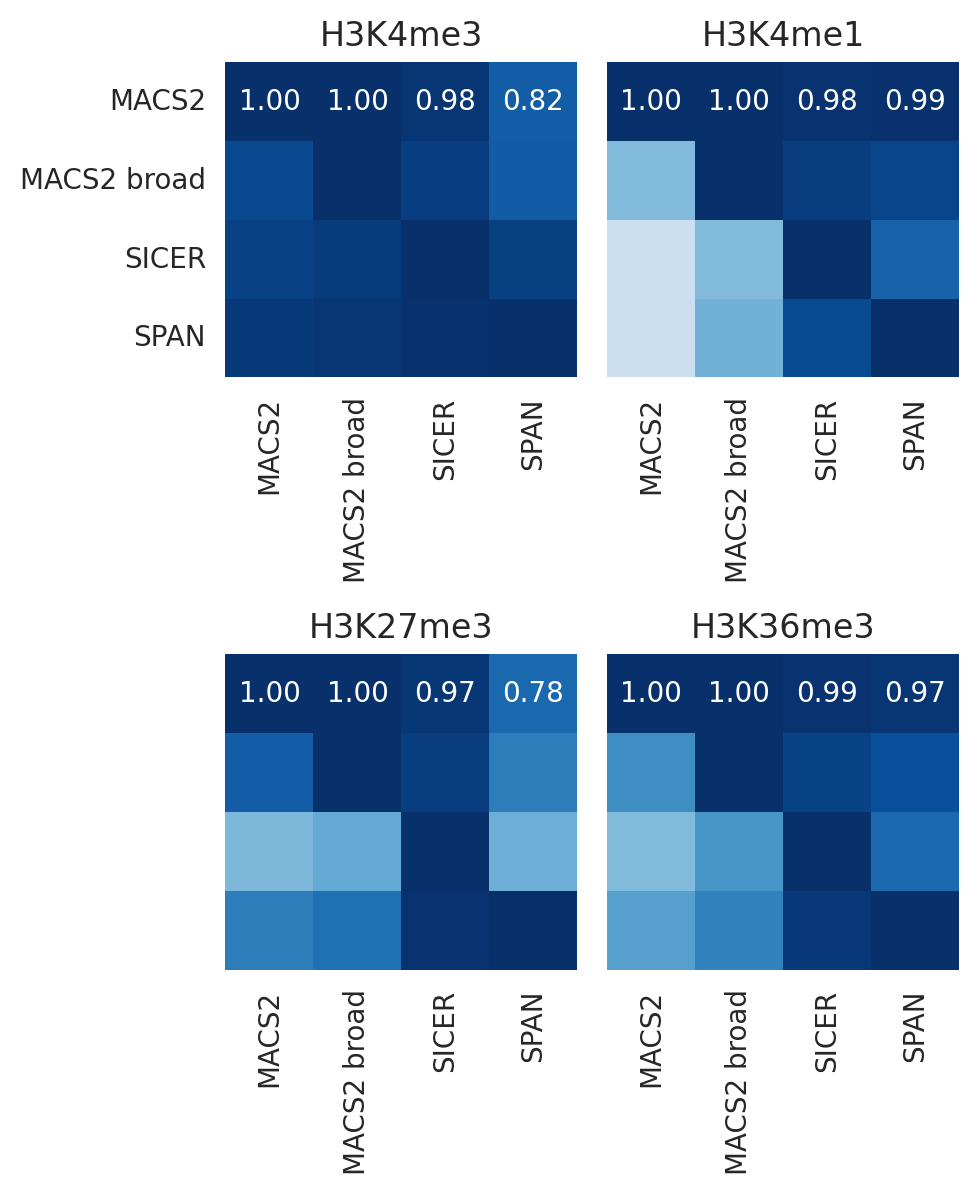

In [44]:
from math import ceil

#Heatmaps
fig = plt.figure(figsize=(5, 8))
for i, m in enumerate(MODIFICATIONS):
    print(m)
    tom = to[to['modification'] == m].groupby(['tool1', 'tool2'])['overlap'].mean().reset_index().copy()
    tomp = tom.pivot(index='tool1', columns='tool2', values='overlap').fillna(1.0)
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tomp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'overlap_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()

## Jaccard between tools

In [45]:
tj = pd.DataFrame(columns=['modification', 'replicate', 'tool1', 'tool2', 'jaccard'], dtype=object)
for _, row in tools_overlap.iterrows():
    m = row['modification']
    rep = row['rep']
    tool1 = row['tool1']
    tool2 = row['tool2']
    length1 = row['length1']
    length2 = row['length2']
    intersection = row['intersect']
    jaccard = d(intersection, length1 + length2 - intersection)
    tj.loc[len(tj)] = (m, rep, tool1, tool2, jaccard)

H3K4me3
H3K4me1
H3K27me3
H3K36me3


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


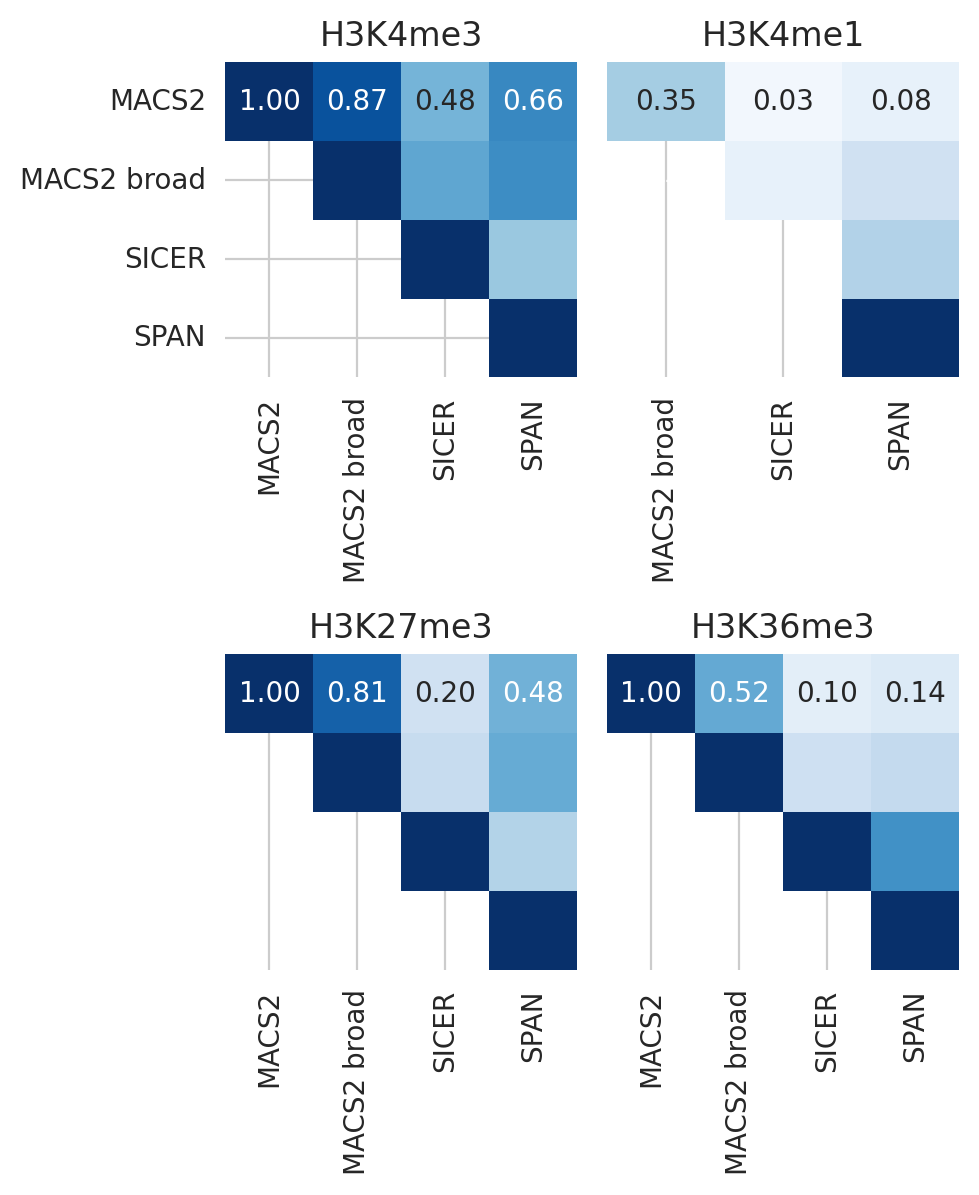

In [46]:
#Heatmaps
fig = plt.figure(figsize=(5, 8))

for i, m in enumerate(MODIFICATIONS):
    print(m)
    tjm = tj[tj['modification'] == m].copy()
    for t in tools:
        tjm.loc[len(tjm)] = (m, 'rep', t, t, 1.0)
    tjm = tjm.groupby(['tool1', 'tool2'])['jaccard'].mean().reset_index().copy()
    tjmp = tjm.pivot(index='tool1', columns='tool2', values='jaccard')
    ax = plt.subplot(3, int(ceil(len(MODIFICATIONS) / 3)), i + 1)
    sns.heatmap(tjmp, ax=ax, vmin=0, vmax=1, annot=True, fmt='.2f',
                yticklabels=(i == 0 or i == 7), cbar=False, cmap='Blues')
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_title(m)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_tools.{EXT}'), bbox_inches='tight', dpi=300)
plt.show()